### Imports

In [17]:
import os
import pickle

import flax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import psutil
from data_io import Dataset, Encoder
from jax.profiler import start_trace, stop_trace
from reinforcement import train_step as reinforce_train_step
from transformer import (MinimalTrainState, Transformer, generate_samples,
                         train_step)

### Data

In [18]:
train = True
file_path = 'train_data/all_6tet.hdf5'
save_path = 'saves/12block_8head_6tet.pkl'
batch_size = 32
num_test_samps = 1_000

log_path = './jax_profiling'

In [19]:
dataset = Dataset(file_path, 1_000)
encoder = Encoder(dataset)

In [20]:
sample_batch_str = dataset.samp_batch(batch_size)
sample_batch, train_label = encoder.encode(sample_batch_str)

### Model Setup

In [21]:
vocab_size = len(encoder.char_to_id)
d_model = 64  # Dimension of embeddings and model
num_layers = 12  # Number of transformer blocks
num_heads = 8  # Number of attention heads
d_ff = 64  # Dimension of the feed-forward network
seq_len = dataset.max_len + 1  # Sequence length
learning_rate = 0.0005
num_train_steps = 500

In [22]:
key = jax.random.PRNGKey(0)
main_key, params_key, dropout_key = jax.random.split(key, 3)

model = Transformer(
    vocab_size=vocab_size,
    d_model=d_model,
    block_size=seq_len,
    num_layers=num_layers,
    num_heads=num_heads,
)

### Train Model

In [7]:
params = model.init(
    {"params": params_key}, sample_batch, training=True
)["params"]

print(
    f"Model initialized. Parameter count: {sum(x.size for x in jax.tree_util.tree_leaves(params))}"
)

state = MinimalTrainState.create(
    params=params,
    apply_fn=model.apply,
    dropout_key=dropout_key,
    learning_rate=learning_rate,
    m_tm1=flax.core.freeze(jax.tree_util.tree_map(jnp.zeros_like, params)),
    v_tm1=flax.core.freeze(jax.tree_util.tree_map(jnp.zeros_like, params)),
    t=0,
    tx = optax.adamw(learning_rate=learning_rate, weight_decay=0.01)
)

test_batch_input, test_batch_label = encoder.encode(dataset.test_data)

losses = {}
test_losses = {}
mem_used = {}

@jax.jit
def get_test_loss(state, test_batch_input, test_batch_label):
    test_logits = state.apply_fn(
        {"params": state.params},
        test_batch_input,
        training=False,
    )

    test_one_hot_labels = jax.nn.one_hot(test_batch_label, num_classes=vocab_size)
    test_loss = optax.softmax_cross_entropy(test_logits, test_one_hot_labels).mean()
    return test_loss

if train:
    print("\n--- Starting Training ---")
    for step in range(num_train_steps):
        batch_input, batch_label = encoder.encode(dataset.samp_batch(batch_size))
        state, loss = train_step(state, batch_input, batch_label)
        mem = psutil.virtual_memory()
        mem_used[step] = (mem.used / (1024 ** 3))

        losses[step] = float(loss)

        if (step) % 100 == 0:

            test_loss = get_test_loss(state, test_batch_input, test_batch_label)
            test_losses[step] = float(test_loss)

    print("\n✅ Training finished.")

    # (pd.Series(losses).astype(float)).plot()
    # (pd.Series(test_losses).astype(float)).plot()

    # with open(save_path, 'wb') as file:
        # pickle.dump(state.params, file)

Model initialized. Parameter count: 605632

--- Starting Training ---

✅ Training finished.


<Axes: >

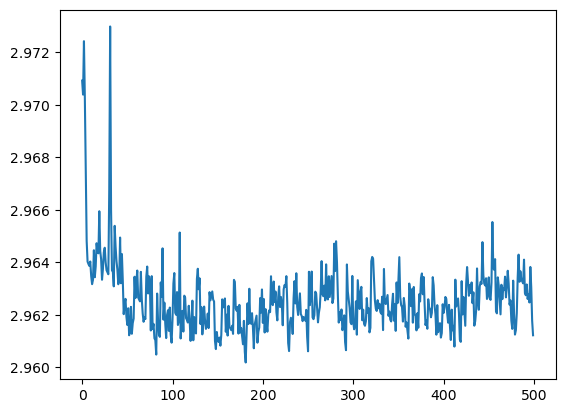

In [8]:
pd.Series(mem_used).plot()

### Load Model

In [23]:
with open('saves/all_run/12block_8head_6tet.pkl', 'rb') as file:
    params = pickle.load(file)

state = MinimalTrainState.create(
    params=params,
    apply_fn=model.apply,
    dropout_key=dropout_key,
    learning_rate=learning_rate,
    m_tm1=flax.core.freeze(jax.tree_util.tree_map(jnp.zeros_like, params)),
    v_tm1=flax.core.freeze(jax.tree_util.tree_map(jnp.zeros_like, params)),
    t=0,
    tx = optax.adamw(learning_rate=learning_rate, weight_decay=0.01)
)

In [32]:
samps_to_gen = 200
bos_id = encoder.char_to_id["[BOS]"]
subkey = jax.random.PRNGKey(42)

samps = generate_samples(state, samps_to_gen, seq_len, subkey, bos_id)
samps_str = encoder.decode(np.array(samps))
valid = [s in dataset for s in samps_str]

### Reinforcement

In [11]:
samps_to_gen = 200
bos_id = encoder.char_to_id["[BOS]"]

In [ ]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

losses = jnp.zeros(100)
scores = jnp.zeros(100)

reinforce_state = MinimalTrainState.create(
    params=state.params,
    apply_fn=model.apply,
    dropout_key=dropout_key,
    learning_rate=learning_rate,
    m_tm1=flax.core.freeze(jax.tree_util.tree_map(jnp.zeros_like, params)),
    v_tm1=flax.core.freeze(jax.tree_util.tree_map(jnp.zeros_like, params)),
    t=0,
    tx = optax.adamw(learning_rate=1e-4, weight_decay=0.01)
)

res = jax.lax.fori_loop(
    0,
    100,
    lambda i, val: (
        *train_step(i, val[0], val[1], samps_to_gen, seq_len, bos_id, dataset, encoder),
        jnp.put(val[4], i, val[2], inplace=False),
        jnp.put(val[5], i, val[3], inplace=False),
    ),
    (reinforce_state, key, 0, 0, losses, scores),
)

In [14]:
# samps = generate_samples(ret[0], samps_to_gen, seq_len, ret[1], bos_id)